In [1]:
%cd /content/drive/MyDrive/python
# raw_data is imported from global config

/content/drive/MyDrive/python


In [2]:
import os
os.getcwd()

'/content/drive/MyDrive/python'

In [3]:
%%capture
! pip install hdf5storage
! pip install mne==0.23.0
! pip install torch
! pip install PIL
! pip install tensorboardX
! pip install tqdm
! pip install TextGrid==1.5

In [4]:
from speech_Ruijin.transformer.lib.train import *
# if error happens, change this: "from scipy.misc import logsumexp" to "from scipy.special import logsumexp"
import PIL
import io
from torchvision.transforms import ToTensor
import numpy as np
#import matplotlib
#matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
npr.seed(0)
torch.manual_seed(1)
torch.cuda.manual_seed_all(2)

from speech_Ruijin.utils import fold_2d23d
from speech_Ruijin.config import data_dir
from datetime import datetime
import pytz
from tensorboardX import SummaryWriter
from pre_all import computer, debugging, running_from_CMD



pre_all: Running from CMD.


In [5]:
sid = 3
mel_bins=23

testing=False
testing=(testing or debugging or computer=='mac')
print('sid: '+str(sid)+ '; Testing mode:'+str(testing))
the_time=datetime.now(pytz.timezone('Asia/Shanghai'))
#result_dir=data_dir+'seq2seq_transformer/sid_'+str(sid)+'/'+ the_time.strftime('%Y_%m_%d') + '_' + the_time.strftime('%H_%M')+'/'
dataname='SingleWordProductionDutch'
result_dir=data_dir+'seq2seq_transformer/'+dataname+'/'+'mel_'+str(mel_bins)+'/sid_'+str(sid)+'/'\
           +the_time.strftime('%Y_%m_%d') + '_' + the_time.strftime('%H_%M')
if testing:
    result_dir=result_dir+'_testing/'
else:
    result_dir=result_dir+'/'
if not os.path.exists(result_dir):
    os.makedirs(result_dir)
print('Result dir: '+ result_dir+'.')
writer = SummaryWriter(result_dir)

sid: 3; Testing mode:False
Result dir: /content/drive/MyDrive/data/speech_RuiJin/seq2seq_transformer/SingleWordProductionDutch/mel_23/sid_3/2023_07_25_00_57/.


In [6]:
%%capture
! pip install pynwb==2.3.2
! pip install resampy==0.4.2

In [7]:
continous_data=True
from speech_Ruijin.dataset import dataset_Dutch
x, y = dataset_Dutch(dataset_name=dataname, sid=sid, mel_bins=mel_bins, continous=continous_data)
#x, y = get_data(dataname=dataname, sid=sid,continous_data=continous_data,mel_bins=mel_bins)  # x: (512482,127), y:(344858, 80)
print('Finish reading data.')
xy_ratio = y.shape[0] / x.shape[0]


Read EEG file: /content/drive/MyDrive/data/SingleWordProductionDutch/sub-03/ieeg/sub-03_task-wordProduction_ieeg.nwb
Finish reading data.


In [8]:
lenx=x.shape[0]
leny=y.shape[0]
train_x=x[:int(lenx * 0.8),:] # (246017, 127)
val_x=x[int(lenx * 0.8):int(lenx * 0.9),:]
test_x=x[int(lenx * 0.9):,:]
train_y=y[:int(leny * 0.8),:]
val_y=y[int(leny * 0.8):int(leny * 0.9),:]
test_y=y[int(leny * 0.9):,:]

In [9]:

norm_mel=False
if norm_mel:
    mu = np.mean(y, axis=0)
    std = np.std(y, axis=0)
    y = (y - mu) / std

norm_EEG=True
if norm_EEG:
    mu=np.mean(train_x,axis=0)
    std=np.std(train_x,axis=0)
    train_x=(train_x-mu)/std

    mu = np.mean(val_x, axis=0)
    std = np.std(val_x, axis=0)
    val_x=(val_x-mu)/std

    mu = np.mean(test_x, axis=0)
    std = np.std(test_x, axis=0)
    test_x=(test_x-mu)/std
use_pca=False
if use_pca:
    from sklearn.decomposition import PCA
    pca = PCA() #  (n_samples, n_features)
    numComps=100
    #Fit PCA to training data
    pca.fit(train_x)
    #Get percentage of explained variance by selected components
    explainedVariance =  np.sum(pca.explained_variance_ratio_[:numComps])
    #Tranform data into component space
    train_x=np.dot(train_x, pca.components_[:numComps,:].T)
    val_x = np.dot(val_x, pca.components_[:numComps,:].T)
    test_x = np.dot(test_x, pca.components_[:numComps,:].T)

In [10]:

# shape: (1000batch, 300time, 10channel)
win=100
if testing:
    stride=100
else:
    stride=10
sf_EEG=1024
history=0.15 # s history data
history=int(history*sf_EEG)
win_x, win_y, shift_x, shift_y = win+history, win* xy_ratio, stride, stride * xy_ratio
x_train,y_train=fold_2d23d(train_x.transpose(),train_y[history:,:].transpose(), win_x, win_y, shift_x,shift_y)
x_val,y_val=fold_2d23d(val_x.transpose(),val_y[history:,:].transpose(), win_x, win_y, shift_x,shift_y)
x_train,y_train,x_val,y_val=[x.transpose(0,2,1) for x in (x_train,y_train,x_val,y_val)]

stride_test=stride # could be different from train/val stride
win_x, win_y, shift_x, shift_y = win+history, win* xy_ratio, stride_test, stride_test * xy_ratio
x_test,y_test=fold_2d23d(test_x.transpose(),test_y[history:,:].transpose(), win_x, win_y, shift_x,shift_y)
x_test,y_test=x_test.transpose(0,2,1),y_test.transpose(0,2,1)
input_d, output_d = x_train.shape[2], y_train.shape[2]
input_len=x_train.shape[1]
out_len = y_val.shape[1]
print('input_d: '+str(input_d)+', input length: '+str(input_len)+', output_d: '+str(output_d)+' ,output length: '+str(out_len)+'.')


input_d: 127, input length: 253, output_d: 23 ,output length: 100.


In [11]:
from common_dl import myDataset
dataset_train = myDataset(x_train, y_train)
dataset_val = myDataset(x_val, y_val)
dataset_test = myDataset(x_test, y_test)

batch_size = 128
dataloader_train = DataLoader(dataset=dataset_train,batch_size=batch_size,shuffle=True)
dataloader_val = DataLoader(dataset=dataset_val,batch_size=batch_size,shuffle=True)
batch_number=len(dataloader_train)
#batch_size=1
dataloader_test = DataLoader(dataset=dataset_test,batch_size=batch_size,shuffle=False)


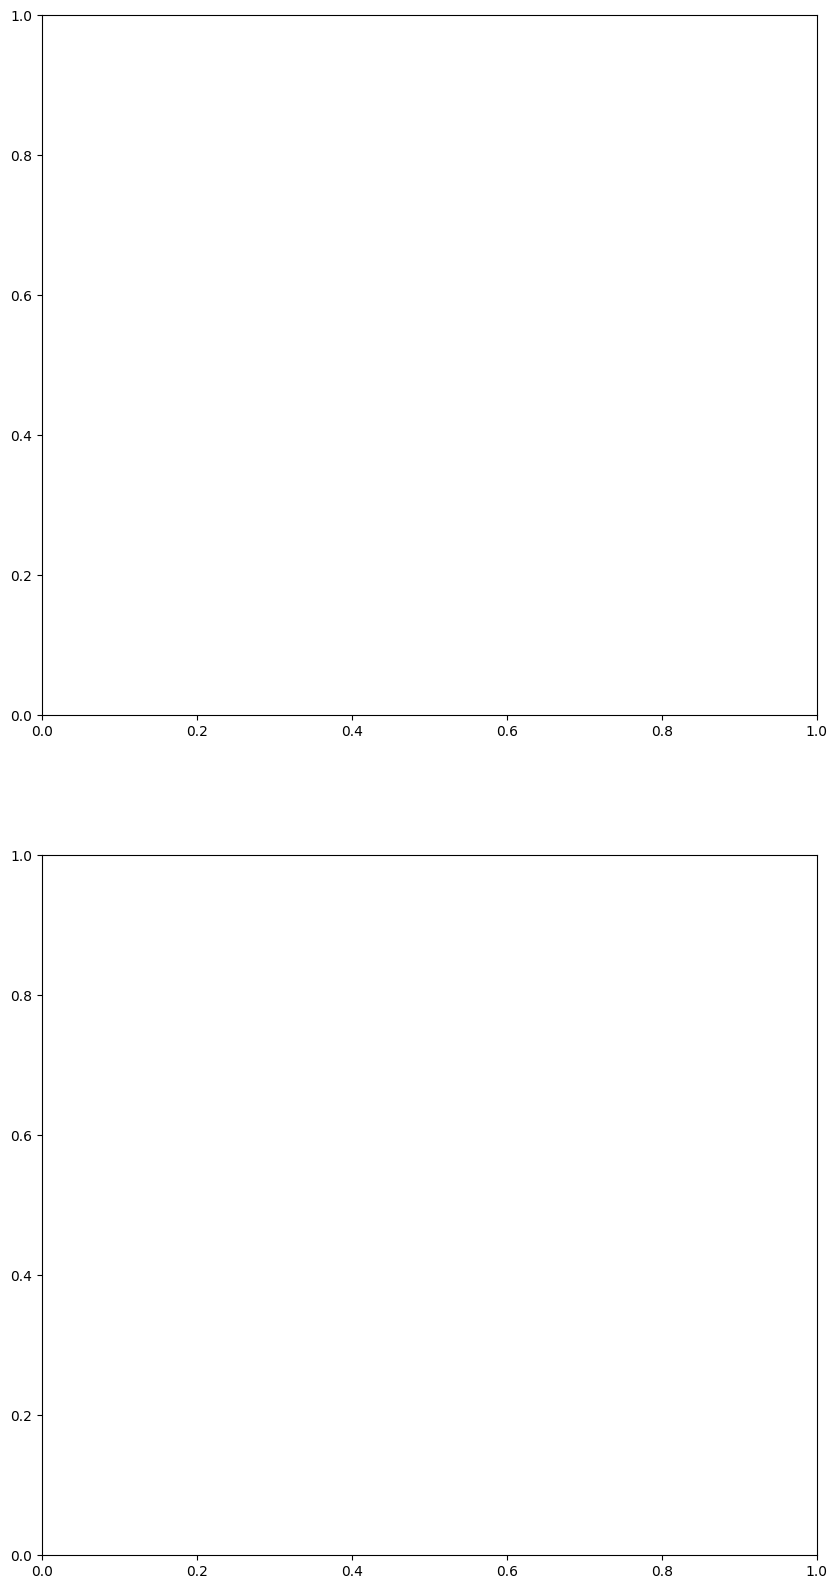

In [12]:

opt = {}
opt['norm_mel'] = norm_mel
opt['Transformer-layers'] = 6 # 6
opt['Model-dimensions'] = 256 # 256
opt['feedford-size'] = 512 # 512
opt['headers'] = 8 # 8
opt['dropout'] = 0.2
opt['src_d'] = input_d # input dimension
opt['tgt_d'] = output_d # output dimension
opt['out_len'] = out_len

from pre_all import device
criterion = nn.MSELoss() # mean squared error
# setup model using hyperparameters defined above
encoder_only=False
spatial_attention=False
model = make_model(opt['src_d'],opt['tgt_d'],N=opt['Transformer-layers'],
                   d_model=opt['Model-dimensions'],d_ff=opt['feedford-size'],h=opt['headers'],
                   dropout=opt['dropout'],norm_mel=opt['norm_mel'],encoder_only=encoder_only,spatial_attention=spatial_attention).to(device)

# setup optimization function
model_opt = NoamOpt(model_size=opt['Model-dimensions'], factor=1, warmup=400,
        optimizer = torch.optim.Adam(model.parameters(), lr=0.002, betas=(0.9, 0.98), eps=1e-9))
#optimizer = torch.optim.Adam(model.parameters(), lr=0.015, betas=(0.9, 0.98), eps=1e-9)

resume=False
if resume:
    print('Load pre-trained model.')
    check_file='H:/Long/data/speech_Ruijin/seq2seq_transformer/2023_07_07_17_04/99.pth'
    from common_dl import device
    checkpoint = torch.load(check_file,map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model_opt.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    resume_epoch=checkpoint['epoch']
else:
    resume_epoch=0

fig,ax=plt.subplots(2,1, figsize=(10,20))
#fig_att,ax_att=plt.subplots(figsize=(10,20))
total_epoch = 100
patients=10
train_losses = []
val_losses = []
val_teacher_force=False
# log some meta data
opt_str='win: '+str(win)+ ', stride: '+str(stride)+ ', norm_EEG: '+str(norm_EEG)+', norm_mel: '+str(norm_mel) \
        +', val_teacher_force:'+str(val_teacher_force)+', spatial_attention:'+str(spatial_attention)\
        +' encoder_only:'+str(encoder_only)+' .Batch_size:'+str(batch_size)+' .layers: '+str(opt['Transformer-layers'])+\
        ' ,model_d: '+str(opt['Model-dimensions'])+\
        ', ffd size: '+str(opt['feedford-size'])+' ,headers: '+str(opt['headers'])+' ,dropout: '+str(opt['dropout'])
experiment_description = dataname + str(sid) + ": " + opt_str
writer.add_text('Experiment description', experiment_description, 0)


In [ ]:

from tqdm import tqdm
att_encoders, att_decoders, att_enc_decs=[],[],[] # [total_epoch,N, 64, 8, 99, 99]
for epoch in tqdm(range(total_epoch)):
    epoch = epoch + resume_epoch
    model.train()
    train_loss,pred,truth,att_encoder, att_decoder, att_enc_dec = run_epoch(epoch,batch_number,writer,data_gen(dataloader_train,encoder_only=encoder_only), model,SimpleLossCompute(model.generator, criterion, model_opt))
    # N*[8, 99, 99]-cat->[N, 8, 99, 99]
    att_encoders.append(np.concatenate(att_encoder)) # N*[8, 99, 99]
    att_decoders.append(np.concatenate(att_decoder))
    att_enc_decs.append(np.concatenate(att_enc_dec))
    #train_loss, pred, truth = run_epoch(data_gen(dataloader_train), model,criterion,optimizer)
    train_losses.append(train_loss)


    ax[0].imshow(truth.cpu()[-1,:, :].numpy().squeeze(), cmap='RdBu_r')
    ax[1].imshow(pred.cpu()[-1,:, :].detach().numpy().squeeze(), cmap='RdBu_r')
    buf = io.BytesIO()
    plt.savefig(buf, format='jpeg')
    buf.seek(0)
    image = PIL.Image.open(buf)
    image = ToTensor()(image).unsqueeze(0)
    writer.add_image('Image/train', image[0], epoch)
    ax[0].clear()
    ax[1].clear()

    # attention plot: att_encoders: [N, 8, 99, 99]
    ax[0].imshow(att_encoder[-1][0,:,:], cmap='RdBu_r') # -1:last encoder layer, 0:the first head
    buf = io.BytesIO()
    plt.savefig(buf, format='jpeg')
    buf.seek(0)
    image = PIL.Image.open(buf)
    image = ToTensor()(image).unsqueeze(0)
    writer.add_image('attention/encoder', image[0], epoch)
    ax[0].clear()

    ax[0].imshow(att_decoder[-1][0, :, :], cmap='RdBu_r')  # -1:last encoder layer, 0:the first head
    buf = io.BytesIO()
    plt.savefig(buf, format='jpeg')
    buf.seek(0)
    image = PIL.Image.open(buf)
    image = ToTensor()(image).unsqueeze(0)
    writer.add_image('attention/decoder', image[0], epoch)
    ax[0].clear()

    ax[0].imshow(att_enc_dec[-1][0, :, :], cmap='RdBu_r')  # -1:last encoder layer, 0:the first head
    buf = io.BytesIO()
    plt.savefig(buf, format='jpeg')
    buf.seek(0)
    image = PIL.Image.open(buf)
    image = ToTensor()(image).unsqueeze(0)
    writer.add_image('attention/enc_dec', image[0], epoch)
    ax[0].clear()

    print('Validating...')
    model.eval() # test the model

    if val_teacher_force:
        #This is a bad validating method, because it uses teacher force like in the training step.
        with torch.no_grad():
            val_loss,pred,truth, att_encoder, att_decoder, att_enc_dec = run_epoch(epoch,batch_number,writer,data_gen(dataloader_val,encoder_only=encoder_only), model,SimpleLossCompute(model.generator, criterion, None))
            #val_loss, pred, truth = run_epoch(data_gen(dataloader_val), model,criterion, None)
            val_losses.append(val_loss)
            val_loss_avg=val_loss
        ax[0].imshow(truth.cpu()[-1, :, :].numpy().squeeze(), cmap='RdBu_r')
        ax[1].imshow(pred.cpu()[-1, :, :].detach().numpy().squeeze(), cmap='RdBu_r')
        buf = io.BytesIO()
        plt.savefig(buf, format='jpeg')
        buf.seek(0)
        image = PIL.Image.open(buf)
        image = ToTensor()(image).unsqueeze(0)
        writer.add_image('Image/val', image[0], epoch)
        ax[0].clear()
        ax[1].clear()

    else:
        predictions = []
        truths = []
        val_losses=[]
        for i, (val_x, val_y) in enumerate(dataloader_val):
            # batch inference
            pred, tgt = output_prediction2(model, val_x, val_y, max_len=opt['out_len'], start_symbol=1,
                                           output_d=opt['tgt_d'],
                                           device=device, encoder_only=encoder_only)
            # the first sample of pred are all 1s
            predictions.append(pred[:,1:,:])
            truths.append(val_y[:,1:,:])
            val_loss = criterion(pred[:,1:,:], val_y[:,1:,:]).item()
            val_losses.append(val_loss)

            writer.add_scalar('val_loss', val_loss, epoch * len(dataloader_val) + i)

        val_loss_avg = sum(val_losses)/len(val_losses)


    if epoch==resume_epoch:
        best_val_loss=val_loss_avg
        patient=patients
        best_model={
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': model_opt.optimizer.state_dict(),
                    'loss': train_loss,
                    }
        # save the best mode
        filename = result_dir + 'best_model_epoch' + str(epoch) + '.pth'
        torch.save(best_model, filename)
    else:
        if val_loss_avg>best_val_loss:
            patient=patient-1
        else:
            best_val_loss = val_loss_avg
            patient=patients
            best_model={
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': model_opt.optimizer.state_dict(),
                    'loss': train_loss,
                    }
            filename = result_dir + 'best_model_epoch' + str(epoch) + '.pth'
            torch.save(best_model, filename)
    print('Epoch[{}/{}], train_loss: {:.6f},val_loss: {:.6f}. Patient: {:d}'.format(epoch, total_epoch+resume_epoch, train_loss, val_loss_avg,patient))

    # save mode every 10 epochs
    if epoch % 10 ==0:
        current_model = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': model_opt.optimizer.state_dict(),
            'loss': train_loss,
        }

        filename = result_dir + str(epoch) + '.pth'
        #torch.save(current_model, filename)


    ## plot testing result every epoch (because training is too slow)
    # not suitable for encoder_only mode; just use the validation dataset to monitor the model performance \
    # (no teacher force in encoder_only mode)
    skip_testing=True
    if not skip_testing:
        print('Testing...')
        for i, (test_x, test_y) in enumerate(dataloader_test):
            #if i > 5:
            test_x, test_y = test_x.numpy(), test_y.numpy()
            test_x, test_y = test_x[0], test_y[0]
            # make a prediction then compare it with its true output
            pred, truth = output_prediction(model, test_x, test_y, max_len=opt['out_len'], start_symbol=1,
                                            output_d=opt['tgt_d'], device=device,encoder_only=encoder_only)

            ax[0].imshow(truth[-1, :, :].squeeze(), cmap='RdBu_r')
            ax[1].imshow(pred[-1, :, :].squeeze(), cmap='RdBu_r')
            filename = result_dir + str(epoch) + '_' + str(i) + '.png'
            fig.savefig(filename)

            if i == 20:
                break
    if patient==0:
        #pass # validation using teacher force can't reflect the true generalization
        break

    if testing:
        break
filename=result_dir+str(best_model['epoch'])+'.pth'
torch.save(best_model,filename)

final_model={
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': model_opt.optimizer.state_dict(),
            'loss': train_loss,
            }

# save and load checkpoint
filename=result_dir+str(epoch)+'_final.pth'
torch.save(final_model,filename)
#device=torch.device('cpu')
checkpoint = torch.load(filename,map_location=device)
model=model.to(device)
model.load_state_dict(checkpoint['model_state_dict'])


# save attention matrix
att={}
att['att_encoders']=np.asarray(att_encoders)
att['att_decoders']=np.asarray(att_decoders)
att['att_enc_decs']=np.asarray(att_enc_decs)
filename=result_dir+'attention_matrix.npy'
np.save(filename, att)

  0%|          | 0/100 [00:00<?, ?it/s]

Validating...


  1%|          | 1/100 [06:16<10:20:50, 376.27s/it]

Epoch[0/100], train_loss: 7.832092,val_loss: 33.987886. Patient: 10
Validating...


  2%|▏         | 2/100 [12:35<10:17:21, 377.97s/it]

Epoch[1/100], train_loss: 0.395792,val_loss: 31.216030. Patient: 10
Validating...


Exception in thread Thread-10:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.10/dist-packages/tensorboardX/event_file_writer.py", line 219, in run
    self._record_writer.flush()
  File "/usr/local/lib/python3.10/dist-packages/tensorboardX/event_file_writer.py", line 69, in flush
    self._py_recordio_writer.flush()
  File "/usr/local/lib/python3.10/dist-packages/tensorboardX/record_writer.py", line 193, in flush
    self._writer.flush()
OSError: [Errno 107] Transport endpoint is not connected
  3%|▎         | 3/100 [18:54<10:11:31, 378.27s/it]

Epoch[2/100], train_loss: 0.455462,val_loss: 9.338175. Patient: 10


In [ ]:
print('Haha')